# LDA and Document Similarity

* [Referência: https://www.kaggle.com/ktattan/lda-and-document-similarity](https://www.kaggle.com/ktattan/lda-and-document-similarity)

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

/home/helder/estudos/tcc-pucmg-2/src/python/tcc-venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('fake.csv', usecols=['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])

# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True, inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,d6280dc33385b7727436e876cd07375338e693e1,NaN,Russia's New MiG-29K Carrier-Based Fighter to ...,Citizen journalism with a punch Russia's New M...,english,russia-insider.com,US
1,948f849a16922f555fea34f406b0373b3f8ff4e2,madrino,,"From the city and county to the White House, t...",english,truth-out.org,US
2,d14bde29515a40e94042317265d058c446f4c4ef,Ian Greenhalgh,Trump and all the other far right leaders are ...,Ian Greenhalgh is a photographer and histori...,english,veteranstoday.com,US
3,bece3ebf34695413c933fcc732a8557ebe22f368,Vincent Taliercio,,Another suggestion would have an independent m...,english,westernjournalism.com,US
4,fc1deca9e87e73b50b782e7c18f3732b2d2d8283,Editor,"The Real Effects of Architecture on the Mind, ...",By Tera Graham\nWe spend an overwhelming amoun...,english,theeventchronicle.com,US


In [3]:
def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [4]:
# Run once
# nltk.download('punkt')

In [5]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 2.676551798979441 min


## Get word frequency

In [6]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280


k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (once in entire corpus)
k = 15,000 is much more reasonable as these have been used at least 13 times in the corpus


In [7]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('rockledg', 1),
 ('americiumberyllium', 1),
 ('tultitlan', 1),
 ('hengest', 1),
 ('ute', 1),
 ('kohmaht', 1),
 ('numunuh', 1),
 ('comancheandkiowa', 1),
 ('locallyorgan', 1),
 ('mirabeau', 1)]

In [8]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('unpunish', 13),
 ('mcgee', 13),
 ('mena', 13),
 ('unclog', 13),
 ('vale', 13),
 ('hosni', 13),
 ('adventist', 13),
 ('epilepsi', 13),
 ('kelsey', 13),
 ('ooh', 13)]

In [9]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11578


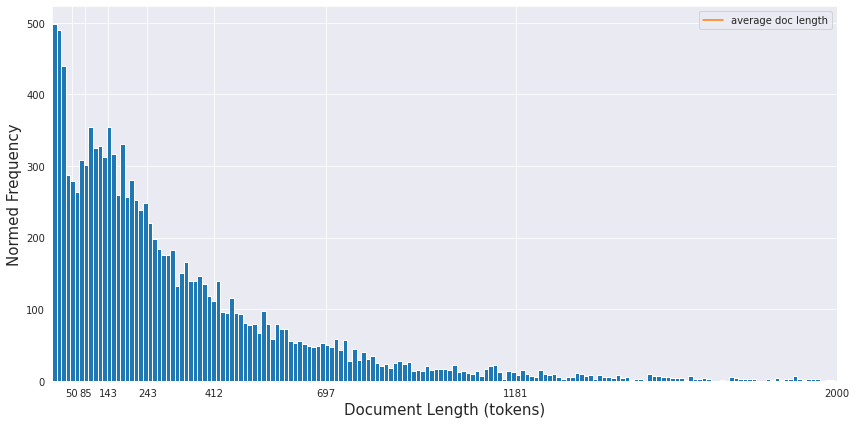

In [12]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6))
# the histogram of the data
# n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Drop short articles

LDA does not work very well on short documents, which we will explain later, so we will drop some of the shorter articles here before training the model.

From the histogram above, droping all articles less than 40 tokens seems appropriate.

In [13]:
print("Before cleaning and excluding short aticles, the dataframe has:", len(df), "articles")
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

Before cleaning and excluding short aticles, the dataframe has: 12357 articles
After cleaning and excluding short aticles, the dataframe now has: 10812 articles


### Split the corpus into training ant testing

Here we will split the corpus into training and testing sets.

The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

The dataframe is already shuffled from the begining, so no need to do it again.

In [14]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [15]:
print(len(df),len(train_df),len(test_df))

10812 10805 7


In [16]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [18]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  10812 articles:  3.7834674596786497 min


### Let's inspect some topics!

Bear in mind, when we see the words they may seem shortened. Recall this is because of our stemming function we previously implemented.

In [19]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(42,
  '0.114*"india" + 0.102*"nuclear" + 0.070*"weapon" + 0.039*"airlin" + 0.037*"north" + 0.037*"indian" + 0.031*"korea" + 0.029*"sam" + 0.026*"waver" + 0.021*"missil" + 0.016*"bomb" + 0.016*"test" + 0.015*"korean" + 0.015*"us" + 0.014*"japan" + 0.012*"south" + 0.012*"program" + 0.010*"kim" + 0.010*"usa" + 0.009*"modi"'),
 (22,
  '0.050*"movi" + 0.036*"johnson" + 0.026*"lloyd" + 0.023*"obstruct" + 0.022*"dougla" + 0.016*"michael" + 0.016*"page" + 0.015*"administ" + 0.014*"show" + 0.013*"matthew" + 0.011*"commanderinchief" + 0.010*"moor" + 0.010*"warn" + 0.010*"dalla" + 0.010*"watch" + 0.009*"week" + 0.009*"stage" + 0.008*"film" + 0.008*"report" + 0.008*"video"'),
 (80,
  '0.068*"new" + 0.054*"radio" + 0.044*"york" + 0.031*"show" + 0.018*"charlott" + 0.017*"host" + 0.016*"ron" + 0.016*"book" + 0.015*"talk" + 0.015*"interview" + 0.014*"citi" + 0.014*"award" + 0.013*"andrew" + 0.013*"stone" + 0.013*"air" + 0.012*"angel" + 0.012*"basebal" + 0.011*"audienc" + 0.011*"time" + 0.011*"night"

In [20]:
lda.show_topic(topicid=4, topn=20)

[('wash', 0.024874844),
 ('accessori', 0.022724563),
 ('mill', 0.020292506),
 ('wood', 0.020201206),
 ('elementari', 0.016444122),
 ('surviv', 0.01634375),
 ('prepar', 0.015071514),
 ('may', 0.010288146),
 ('keep', 0.00998315),
 ('time', 0.009343943),
 ('use', 0.009058776),
 ('garden', 0.008970291),
 ('make', 0.0087854555),
 ('could', 0.008724862),
 ('need', 0.00866332),
 ('dog', 0.008589962),
 ('home', 0.008023083),
 ('heat', 0.0074164164),
 ('also', 0.006752222),
 ('temperatur', 0.0060198833)]

In [21]:
lda.show_topic(topicid=85, topn=20)

[('milit', 0.032567672),
 ('citi', 0.029264294),
 ('forc', 0.02918478),
 ('kill', 0.020334654),
 ('civilian', 0.020015622),
 ('attack', 0.017209355),
 ('armi', 0.017115502),
 ('itali', 0.015829638),
 ('iraqi', 0.015744353),
 ('area', 0.0148768695),
 ('oper', 0.013076269),
 ('terrorist', 0.011238464),
 ('offens', 0.0108398255),
 ('mosul', 0.010597557),
 ('said', 0.010581714),
 ('brigad', 0.010565342),
 ('soldier', 0.009798779),
 ('militari', 0.009468269),
 ('villag', 0.009443585),
 ('report', 0.009183679)]

In [22]:
lda.show_topic(topicid=75, topn=20)

[('gun', 0.07442665),
 ('fire', 0.057615653),
 ('assault', 0.050507054),
 ('violenc', 0.050167747),
 ('weapon', 0.030196065),
 ('shot', 0.027044296),
 ('shoot', 0.02644338),
 ('bullet', 0.026358472),
 ('burn', 0.02381036),
 ('ban', 0.023721294),
 ('violent', 0.022707),
 ('arm', 0.022698965),
 ('rifl', 0.018351456),
 ('firearm', 0.018067913),
 ('attack', 0.014406479),
 ('round', 0.013076012),
 ('polic', 0.009433782),
 ('park', 0.008922288),
 ('right', 0.008458118),
 ('bear', 0.008244995)]

In [23]:
lda.show_topic(topicid=39, topn=20)

[('govern', 0.06276865),
 ('law', 0.060746506),
 ('treati', 0.049664803),
 ('articl', 0.046451867),
 ('nation', 0.045254733),
 ('state', 0.039548945),
 ('us', 0.037408628),
 ('violat', 0.031751424),
 ('constitut', 0.031362887),
 ('shall', 0.02991989),
 ('legal', 0.0274674),
 ('act', 0.02123427),
 ('use', 0.018088726),
 ('congress', 0.017723136),
 ('unit', 0.016455395),
 ('upon', 0.016314812),
 ('power', 0.012965654),
 ('war', 0.009970129),
 ('sign', 0.009884645),
 ('author', 0.009574863)]

What the about above means, is that topic 4 has top contributing words ["judge","case","court",...], which indicates the topic is about court cases. Topic 75 has top contributing words ["god","christian","love",...], which indicates the topic is about religion.

Now, not only can we see the word contribution for each topic, but we can also visualise the topic contribution for each article.

In [28]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

10698


In [25]:
print(train_df.iloc[random_article_index,3])

Posted by Madeline | Oct 30, 2016 | 2016 , Daily Blog | 0 | Thanks Therisa!
The Mind Unleashed 
On November 8th, 2016, hundreds and possibly thousands flash-mob meditations will commence at the polling stations everywhere across America. Elevate The Vote says that “this is a non-partisan participatory event that is open to everyone. It’s about the fundamental unity of human life that seems to have been so forgotten in this campaign.” 
The intention is to “ elevate the consciousness of every U.S. voter on election day, impacting how we feel about ourselves, politics, this election, and each other.” “Meditation gives you an opportunity to come to know your invisible self. It allows you to empty yourself of the endless hyperactivity of your mind, and to attain calmness. It teaches you to be peaceful, to remove stress, to receive answers where confusion previously reigned.” – Dr. Wayne Dyer Image Source 
While many will love this concept, some may be a bit skeptical of it having any effect

In [26]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

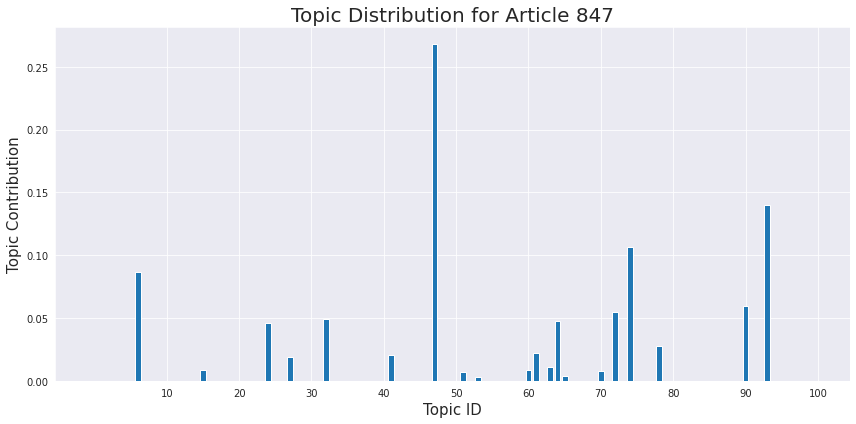

In [27]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

Ok, so clearly this document has various contributions from different topics. But what are these topics? Lets find out!

In [29]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

47 [('unlaw', 0.042286992), ('human', 0.015862409), ('us', 0.013369953), ('basebal', 0.011505012), ('one', 0.011329002), ('way', 0.010998977), ('world', 0.010521986), ('take', 0.009159873), ('need', 0.008168784), ('person', 0.008089446)] 

93 [('year', 0.01768093), ('energi', 0.015423204), ('climat', 0.014994782), ('oil', 0.0124135045), ('chang', 0.012344902), ('million', 0.011498599), ('global', 0.011424082), ('power', 0.011236523), ('ga', 0.010371302), ('world', 0.009047836)] 

74 [('use', 0.02368429), ('also', 0.010436352), ('effect', 0.0103979735), ('orwellian', 0.010247517), ('mani', 0.010153693), ('household', 0.008622767), ('natur', 0.008401275), ('may', 0.007917506), ('one', 0.007763224), ('remedi', 0.0077066263)] 

6 [('earth', 0.017694222), ('light', 0.011689727), ('one', 0.009562817), ('planet', 0.009126079), ('see', 0.00855453), ('moon', 0.008483138), ('time', 0.008434452), ('like', 0.007851339), ('mph', 0.0077210544), ('around', 0.0069669555)] 

90 [('health', 0.096307516)

## Similarity Queries and Unseen Data